In [1]:
%pwd
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [15]:
from deeplifting.models import DeepliftingSkipMLP
from deeplifting.optimization import set_seed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

In [75]:
model = DeepliftingSkipMLP(input_size=512, output_size=2, n=512)

In [76]:
outputs1, outputs2 = model(None)

In [77]:
outputs1 = pd.Series(outputs1[:, 0].detach().numpy())

In [78]:
outputs1.describe()

count    512.000000
mean       0.127735
std        0.335212
min       -1.059084
25%       -0.070468
50%        0.131793
75%        0.359620
max        1.002744
dtype: float64

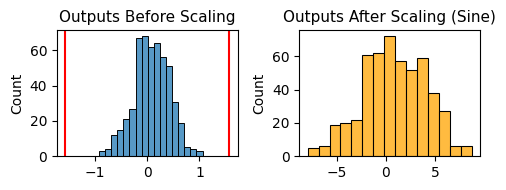

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2))

# Get the neural network outputs before scaling
sns.histplot(outputs1, ax=ax1)
ax1.set_title('Outputs Before Scaling', fontsize=11)
ax1.axvline(-np.pi / 2.0, color='r')
ax1.axvline(np.pi / 2.0, color='r')

# Get the neural network outputs after scaling
a, b = -10.0, 10.0
outputs1_scale = a + (b - a) / 2.0 * (outputs1.apply(np.sin) + 1)
sns.histplot(outputs1_scale, ax=ax2, color='orange')
ax2.set_title('Outputs After Scaling (Sine)', fontsize=11)

fig.tight_layout()
fig.savefig(
    '/Users/ryandevera/data-science/umn_environments/Deeplifting'
    f'/images/scaling.png',
    bbox_inches='tight',
    pad_inches=0.01,
)

<Axes: >

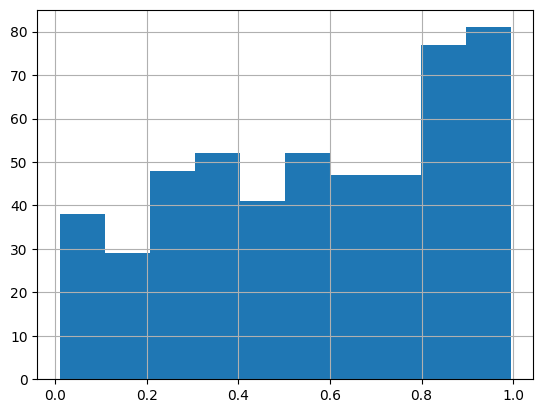

In [55]:
outputs1.apply(lambda x: 1 / (1 + np.exp(-x * 5))).hist()

In [83]:
(outputs1 * 50).apply(np.sinh).describe()

count    5.120000e+02
mean    -9.069004e+19
std               inf
min     -4.973882e+22
25%     -1.733240e+01
50%      3.639210e+02
75%      3.221198e+07
max      2.973519e+21
dtype: float64

In [67]:
np.sinh(-50)

-2.592352764293536e+21